# Preliminaries

The goal of this Jupyter notebook document is to perform simulations of the Kyle-Back model for insider trading with stochastic liquidity. Our primary goal is to examine the behavior of the model when the final stock price has a lognormal distribution and when the distribution has fatter or thinner tails than those implied by the lognormal distribution.

# Notice

This .ipynb file requires function definitions from a .py file which needs to be included in the same folder as this .ipynb file to work correctly. To ensure this file works correctly, please follow the directions below:

Usage:
1. Open kyleback.ipynb and dependencies.ipynb
2. Download dependencies.ipynb as a .py file and place it in the same folder as this .ipynb file.
4. Run kyleback.ipynb normally

# Packages

In [2]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d

import dependencies as dp

# Construction of the Optimal Transport Map

To price options, we'll need to be able to compute $h$ under a variety of different situations. In the below blocks of code, I define two functions which will ultimately allow us to compute $h$ under three different circumstances:
1. Lognormal distribution
2. Modification of the Lognormal distribution with fatter/thinner tails
3. Gaussian Mixture case

## Cases 1 & 2

If the final price is lognormal, then the optimal transport map is given by 
$$ h(x) = m e^{-\frac{1}{2}\sigma^2 + \sigma x} $$
If $x$ is replaced with $f(x)$, where $f(x)$ is a superlinear (resp. sublinear) function, then market maker's prior will be a distribution with fatter tails (resp. thinner tails) $\nu$ than that implied by the lognormal distribution.

The function $h_0$ computes the price at time $0$ given the parameters that we set. If $\nu$ is lognormal, then this value is just $m$, but fattening the tails (resp. thinning the tails) will increase (resp. decrease) $h_0$.

In [8]:
#Defining the optimal transport map
def h(x, m, sigma, s = 1, mode = "superlinear", s_1 = (1,1)):
    #The variable s I will refer to here as the skew factor
    if mode == "superlinear": #Suggestion from myself
        val = m*np.exp(-0.5*(sigma**2)+sigma*(np.log(np.exp(1)+s*(x**2))*x))
    elif mode == "sublinear": #Suggestion from myself
        val = m*np.exp(-0.5*(sigma**2)+sigma*(x/(np.log(np.exp(1)+s*(x**2)))))
    elif mode == "power": #Suggestion from Ekren
        val = m*np.exp(-0.5*(sigma**2)+sigma*(x*(np.abs(x)**(s-1))))
    elif mode == "smirk":
        val = h_smirk(x,m,sigma, s = s_1)
    return val

def h_0(m, sigma, s = 1, mode = "superlinear", num_pts = 1000):
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = norm.ppf(y_pts)
    return np.mean(h(norm_pts, m, sigma, s, mode))

## The Gaussian Mixture Case

We need a separate function for the special case when the logprice is assumed to be a Gaussian mixture.

In [5]:
def hGM(x, weights, means, volatilities, iterations = 4, method = "secant"):
    #Compute h under the assumption that the logarithm of the price is a Gaussian mixture.
    #This demands solving a nonlinear equation
    
    #means correspond to values of ln(m) - 0.5\sigma^2
    #volatilities correspond to values of \sigma^2
    x = x.reshape(-1)
    
    phi_x = norm.cdf(x) #To save computation time
    
    #Setting up our initial guesses
    #Which 2 components of the mixture have the highest weights?
    #Use those components to form the initial guesses
    #print("weights:")
    #print(weights)
    ind = np.argpartition(weights, -2)[-2:] 
    
    y = means[ind[0]] + volatilities[ind[0]]*x
    new_y = means[ind[1]] + volatilities[ind[1]]*x
        
    if method == "secant":
        for i in range(iterations):
            #Secant method iteration
            #print("Iteration " + str(i) + ": ")
            old_y = y
            y = new_y

            #print(old_y)
            #print(y)

            #print(np.shape(GaussianMixtureCDF(np.log(y), weights, means, volatilities)))
            #print(np.shape(phi_x))
            f = dp.GaussianMixtureCDF(y, weights, means, volatilities) - phi_x
            #print(f)
            old_f = dp.GaussianMixtureCDF(old_y, weights, means, volatilities) - phi_x
            #print(old_f)
            new_y = y - f*(y - old_y)/(f - old_f)
            #print(new_y)
    elif method == "bisection":
        ####################################################
        #First, find an interval that the answer must lie in
        ####################################################
        
        #print("Making initial interval guess!")
        y = means[ind[0]] + volatilities[ind[0]]*x
        f = dp.GaussianMixtureCDF(y, weights, means, volatilities) - phi_x
        #print("Initial value of y: " + str(y))
        #print("Initial value of f: " + str(f))
        
        a = np.copy(x)
        b = np.copy(x)
        
        #Setting the interval guesses where our guess has overshot
        if len(np.where(f > 0)[0]) > 0:
            a[np.where(f > 0)[0]] = np.log(1/2) + y[np.where(f > 0)[0]]
            b[np.where(f > 0)[0]] = y[np.where(f > 0)[0]]
        
        #Setting the interval guesss where our guess has undershot
        if len(np.where(f <= 0)[0]) > 0:
            a[np.where(f <= 0)[0]] = y[np.where(f <= 0)[0]]
            b[np.where(f <= 0)[0]] = np.log(2) + y[np.where(f <= 0)[0]]
        
        #print("Initial interval guess: ")
        #print(a)
        #print(b)
        
        #All a guesses need to undershoot while all b guesses need to overshoot.
        #Check for indices where a still overshoots and half the values of a and b for those indices
        #Check for indices where b still undershoots and double the values of a and b for those indices
        i = 0
        f_a = dp.GaussianMixtureCDF(a, weights, means, volatilities) - phi_x
        f_b = dp.GaussianMixtureCDF(b, weights, means, volatilities) - phi_x
        #print("Checking a and b values: ")
        #print(f_a)
        #print(f_b)
        
        #print(len(np.where(f_a > 0)[0]))
        
        while i < iterations and (len(np.where(f_a > 0)[0]) > 0 or len(np.where(f_b < 0)[0]) > 0):
            i = i + 1 #Fail-safe
            
            if len(np.where(f_a > 0)[0]) > 0:
                b[np.where(f_a > 0)[0]] = a[np.where(f_a > 0)[0]]
                a[np.where(f_a > 0)[0]] = np.log(1/2) + a[np.where(f_a > 0)[0]]
            
            if len(np.where(f_b < 0)[0]) > 0:
                a[np.where(f_b < 0)[0]] = b[np.where(f_b < 0)[0]]
                b[np.where(f_b < 0)[0]] = np.log(2) + b[np.where(f_b < 0)[0]]
            
            f_a = dp.GaussianMixtureCDF(a, weights, means, volatilities) - phi_x
            f_b = dp.GaussianMixtureCDF(b, weights, means, volatilities) - phi_x
            
            #print("Updated interval guess: ")
            #print(a)
            #print(b)
        
        #print("Final interval guess: ")
        #print(a)
        #print(b)
        
        #print("So our answer should be in between...")
        #print(np.exp(a))
        #print(np.exp(b))
        
        ########################################################################
        #Once we've made a suitable guess interval, it's time to perform iterations to get us closer to the answer
        #Let's use bisection method.     
        for i in range(iterations):
            t = (a + b)/2
            #print("t after iteration " + str(i) + ": ")
            #print(t)
            f_t = dp.GaussianMixtureCDF(t, weights, means, volatilities) - phi_x
            f_a = dp.GaussianMixtureCDF(a, weights, means, volatilities) - phi_x
            
            f_t*f_a > 0
            b[np.where(f_t*f_a < 0)[0]] = t[np.where(f_t*f_a < 0)[0]]
            a[np.where(f_t*f_a > 0)[0]] = t[np.where(f_t*f_a > 0)[0]]
        
        y = (a + b)/2
        
        #print("Final answer before exp: ")
        #print(y)

    return np.exp(y)

In [6]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.25 0.5  0.25]
Mean Prices: [0.79600998 0.8824969  1.19401498]
Volatilities: [0.1 0.5 0.1]


In [7]:
n = 25
x = np.array([-3 + 2*(i/(n-1)) for i in range(n)])
print(x)
y1 = hGM(x, weights, means, volatilities, iterations = 20, method = "bisection")
print(x)
y2 = hGM(x, weights, means, volatilities, iterations = 5, method = "secant")

print("Deviations in guesses:")
print(y1 - y2)

[-3.         -2.91666667 -2.83333333 -2.75       -2.66666667 -2.58333333
 -2.5        -2.41666667 -2.33333333 -2.25       -2.16666667 -2.08333333
 -2.         -1.91666667 -1.83333333 -1.75       -1.66666667 -1.58333333
 -1.5        -1.41666667 -1.33333333 -1.25       -1.16666667 -1.08333333
 -1.        ]
[-3.         -2.91666667 -2.83333333 -2.75       -2.66666667 -2.58333333
 -2.5        -2.41666667 -2.33333333 -2.25       -2.16666667 -2.08333333
 -2.         -1.91666667 -1.83333333 -1.75       -1.66666667 -1.58333333
 -1.5        -1.41666667 -1.33333333 -1.25       -1.16666667 -1.08333333
 -1.        ]
Deviations in guesses:
[0.00033361 0.00034377 0.00035292 0.00036052 0.00036635 0.00037007
 0.00037108 0.00036948 0.00036471 0.00035655 0.00034522 0.00033047
 0.0003124  0.00029173 0.00026854 0.0002434  0.00021727 0.00019074
 0.0001654  0.00014619 0.00015199 0.00025286 0.00070293 0.00209165
 0.00430103]


# Graphing the PDF

In this portion of the Jupyter Notebook, I write code which graphs the PDF of $P_T|\mathcal{F}_t^m$ in a some special cases, including:
1. The standard lognormal case.
2. The superlinear/sublinear case.
3. The Gaussian mixture case.

I'm going to start off with the Gaussian mixture case, as this one requires special attention and is quite complicated. To start off, we need a way to compute $h'(x)$ and do so using a vectorized function.

## PDF of the Final Price

First, let me give code for the PDF of the final price given the market maker's info at the time t. Here's the Gaussian mixture case

In [8]:
def pricePDFgaussianMixture(x, xi, liquidity, weights, means, volatilities):
    #Better version of code above based on suggestions from Ekren
    
    #First, we need to compute values of the pdf and cdf of nu.
    #Remember that our price is distributed as exp(Y), where Y is Gaussian mixture
    #This means I can't naively plug in x into the below functions, hence the "extra" stuff
    F = dp.GaussianMixtureCDF(np.log(x), weights, means, volatilities)
    f = dp.GaussianMixturePDF(np.log(x), weights, means, volatilities)/x
    
#     print("Values of F:")
#     print(F)
    
#     print("Values of f:")
#     print(f)
    
    return x, norm.pdf((norm.ppf(F) - xi)/np.sqrt(liquidity))*(f/(np.sqrt(liquidity)*norm.pdf(norm.ppf(F))))

Now let's take care of the lognormal case:

In [9]:
def pricePDFlognormal(x, xi, liquidity, mean, volatility):
    h_inv = (np.log(x/mean) + 0.5*(volatility**2))/volatility
    return x, norm.pdf((h_inv - xi)/liquidity)/(np.sqrt(liquidity)*volatility*x)

Let's show these functions in action:

### Gaussian Mixture Example Use Case

In [10]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.25 0.5  0.25]
Mean Prices: [0.79600998 0.8824969  1.19401498]
Volatilities: [0.1 0.5 0.1]


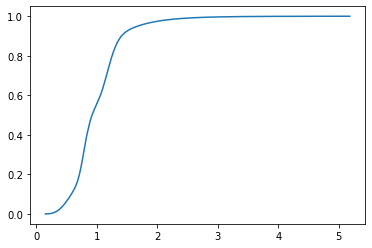

In [11]:
xi = 0
liquidity = 1

n = 10000
x = np.array([(i+1)/(n+1) for i in range(n)])
argument = hGM(xi + np.sqrt(liquidity)*norm.ppf(x), weights, means, volatilities, iterations = 15, method = "bisection")

plt.plot(argument,x)

Text(0, 0.5, 'PDF value')

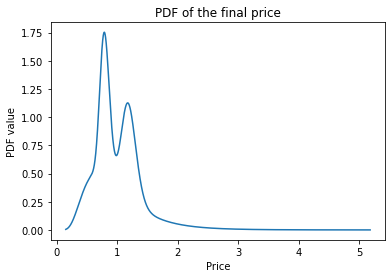

In [12]:
x_part, y_part = pricePDFgaussianMixture(argument, xi, liquidity, weights, means, volatilities)
plt.plot(x_part,y_part)
plt.title("PDF of the final price")
plt.xlabel("Price")
plt.ylabel("PDF value")

### Lognormal Example Use Case

In [13]:
mean = 1
volatility = 0.2
n = 10000
xi = -1
liquidity = 0.8

First, let's graph the CDF

In [14]:
t = np.array([(i+1)/(n+1) for i in range(n)])
x = mean*np.exp(-0.5*(volatility**2) + volatility*(xi + np.sqrt(liquidity)*norm.ppf(t)))

Text(0.5, 1.0, 'PDF of the Final Price')

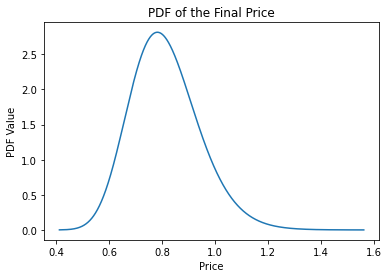

In [15]:
x_part, y_part = pricePDFlognormal(x, xi, liquidity, mean, volatility)
plt.plot(x_part,y_part)
plt.xlabel("Price")
plt.ylabel("PDF Value")
plt.title("PDF of the Final Price")

## The PDF Crossing Problem

In Glasserman & Pirjol, a way to classify the shape of the IV curve in terms of comparison with crossings of a lognormal PDF is given. How the result works is like this:

1. Graph the distribution of $P_T|\mathcal{F}_t^m = h(\xi_t + \sqrt{\Sigma_t}G)$
2. Let $m = E(P_T|\mathcal{F}_t^m) = h(\xi_t + \sqrt{\Sigma_t}G)$. On the same plot, graph the distribution of the random variable $X_v = m\exp(-\frac{1}{2}v^2 + vG)$.
3. Count the number of times the two graphs cross. This number is the amount of the times the IV curve for options will cross the level $v$.

In the previous part, we constructed functions precisely for the purpose of accomplishing tasks 1 and 2. In this section, we accomplish task 3.

The Gaussian mixture case is of particular importance to us, so we will begin with this use case. Let's start by defining our parameters for the prior.

In [16]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.25 0.5  0.25]
Mean Prices: [0.79600998 0.8824969  1.19401498]
Volatilities: [0.1 0.5 0.1]


Now, let's determine our parameters for $\xi_t$ and $\Sigma_t$ and using these determine the current price of the stock. (We need this for the lognormal graph.)

In [17]:
xi = 0.5
liquidity = 0.5

n = 10000
x = np.array([(i+1)/(n+1) for i in range(n)])
argument_GM = hGM(xi + np.sqrt(liquidity)*norm.ppf(x), weights, means, volatilities, iterations = 15, method = "bisection")
forward_price = np.mean(argument_GM)
print("The price given the current parameters is: " + str(forward_price))

The price given the current parameters is: 1.156296316386803


Now, I want to graph *two* curves on the same graph. We want the distribution of the final stock price and the distribution of the psuedo-price placed on the same graph.

Text(0, 0.5, 'PDF value')

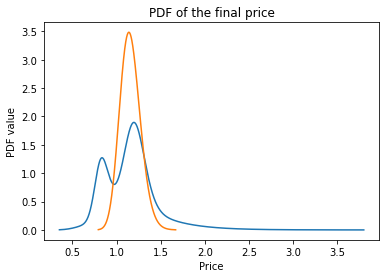

In [18]:
v = 0.1
argument_log = forward_price*np.exp(-0.5*v**2 + v*norm.ppf(x))

x_part_GM, y_part_GM = pricePDFgaussianMixture(argument_GM, xi, liquidity, weights, means, volatilities)
x_part_log, y_part_log = pricePDFlognormal(argument_log, 0, 1, forward_price, v)
plt.plot(x_part_GM,y_part_GM)
plt.plot(x_part_log,y_part_log)
plt.title("PDF of the final price")
plt.xlabel("Price")
plt.ylabel("PDF value")

On the same graph above, let's put a lognormal RV with the same spot price and some variance level:

In [19]:
hGM(xi + np.sqrt(liquidity)*norm.ppf(x), weights, means, volatilities, iterations = 15, method = "bisection")

array([0.35242564, 0.37836284, 0.3951611 , ..., 3.41067368, 3.55306765,
       3.80022422])

## Constructing Smirks

In [20]:
def h_smirk(x, m, sigma, s = (0,0), mode = ("sublinear", "superlinear")):
    return np.where(x < 0, h(x, m, sigma, s = s[0], mode = mode[0]), h(x, m, sigma, s = s[1], mode = mode[1]))

In [21]:
n = 100
a = np.array([-0.5 + i/(n-1)*1 for i in range(n)])
prices = h_smirk(a, 100, 0.2, s = (1,1), mode = ("superlinear", "sublinear"))
np.set_printoptions(suppress=True)
display(prices)

array([ 87.91512482,  88.13770466,  88.35915339,  88.57948558,
        88.79871656,  89.01686248,  89.23394024,  89.44996756,
        89.66496293,  89.87894561,  90.09193567,  90.30395394,
        90.51502203,  90.72516234,  90.93439804,  91.14275304,
        91.35025205,  91.55692052,  91.76278465,  91.96787139,
        92.17220844,  92.37582423,  92.57874791,  92.78100935,
        92.98263913,  93.18366856,  93.38412959,  93.5840549 ,
        93.78347783,  93.98243237,  94.18095319,  94.37907557,
        94.57683545,  94.77426936,  94.97141447,  95.16830853,
        95.36498986,  95.56149736,  95.75787049,  95.95414926,
        96.15037417,  96.34658629,  96.54282715,  96.73913879,
        96.93556371,  97.13214488,  97.32892569,  97.52594998,
        97.72326201,  97.92090642,  98.11892639,  98.31732257,
        98.51605272,  98.71507242,  98.91433704,  99.11380176,
        99.31342162,  99.51315158,  99.71294658,  99.91276155,
       100.11255151, 100.31227159, 100.51187711, 100.71

## Demonstration of the Optimal Transport Map

Here I show how changing the constant s impacts tail fatness in the superlinear and sublinear cases:

Text(0, 0.5, 'Probability')

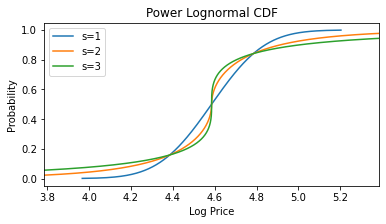

In [22]:
size = 1000
m = 100
sigma = 0.2

fig, ax = plt.subplots()
fig.set_size_inches(6,3)

a = [(i+1)/(size+1) for i in range(size)]

ax.set_title("Power Lognormal CDF")

s_vars = [1,2,3]

ax.plot(np.log(h(norm.ppf(a),m,sigma, s=s_vars[0], mode="power")), a)
ax.plot(np.log(h(norm.ppf(a),m,sigma, s=s_vars[1], mode="power")), a)
ax.plot(np.log(h(norm.ppf(a),m,sigma, s=s_vars[2], mode="power")), a)
ax.legend(['s='+str(s_vars[0]),'s='+str(s_vars[1]),'s='+str(s_vars[2])])
ax.set_xlim(np.log(m*np.exp(-0.5*(sigma**2)-4*sigma)),np.log(m*np.exp(-0.5*(sigma**2)+4*sigma)))
ax.set_xlabel("Log Price")
ax.set_ylabel("Probability")


# for i in range(3):
#     if i == 0:
#         mode = "superlinear"
#         ax[i].set_title("Superlinear Lognormal CDF")
#     elif i == 1:
#         mode = "sublinear"
#         ax[i].set_title("Sublinear Lognormal CDF")
#     elif i == 2:
#         mode = "power"
#         ax[i].set_title("Power Lognormal CDF")
    
#     ax[i].plot(np.log(h(norm.ppf(a),m,sigma, s=1, mode=mode)), a)
#     ax[i].plot(np.log(h(norm.ppf(a),m,sigma, s=2, mode=mode)), a)
#     ax[i].plot(np.log(h(norm.ppf(a),m,sigma, s=3, mode=mode)), a)
#     ax[i].legend(['s=1','s=1.25','s=1.5'])
#     ax[i].set_xlim(np.log(m*np.exp(-0.5*(sigma**2)-4*sigma)),np.log(m*np.exp(-0.5*(sigma**2)+4*sigma)))
#     ax[i].set_xlabel("Log Price")
#     ax[i].set_ylabel("Probability")
    
#     fig.tight_layout()
    

## Effect of Superlinearity and Sublinearity on Price Levels

I show empirically how the $x$th percentile price level is affected by tail fatness for percentile levels $x \in \{1,\ldots, 5\}$ and $x \in \{95, \ldots, 99\}$. 

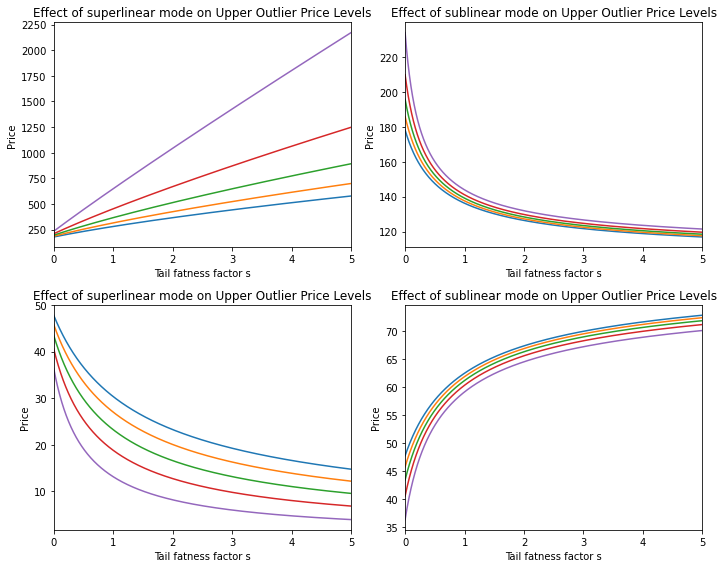

In [23]:
size = 10000
skews = 5*np.array([i/(size-1) for i in range(size)])
m = 100
sigma = 0.4

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10,8)


for i in range(2):
    for j in range(2):
        if i == 0:
            base = 0.95
            interval = 0.01
        else:
            base = 0.05
            interval = -0.01
        
        if j == 0:
            mode = "superlinear"
        else:
            mode = "sublinear"
        
        ax[i,j].plot(skews, h(norm.ppf(base + 0*interval),m,sigma, s=skews, mode=mode))
        ax[i,j].plot(skews, h(norm.ppf(base + 1*interval),m,sigma, s=skews, mode=mode))
        ax[i,j].plot(skews, h(norm.ppf(base + 2*interval),m,sigma, s=skews, mode=mode))
        ax[i,j].plot(skews, h(norm.ppf(base + 3*interval),m,sigma, s=skews, mode=mode))
        ax[i,j].plot(skews, h(norm.ppf(base + 4*interval),m,sigma, s=skews, mode=mode))
        ax[i,j].set_xlim([0,5])
        ax[i,j].set_title("Effect of " + mode + " mode on Upper Outlier Price Levels")
        ax[i,j].set_xlabel("Tail fatness factor s")
        ax[i,j].set_ylabel("Price")

fig.tight_layout()

## Evolution of the Pricing Function Over Time

This shows that it is easy to compute a numerical solution to the pricing rule $R_\xi(t, \xi)$ when $h$ has the desired properties. But what about getting an analytical solution?

In [24]:
def heat_eq_solution(time_pts, x_interval, grid_size, 
                     simulations = 1000, 
                     m = 100, 
                     sigma = 0.4, 
                     s = 0, 
                     mode = "power"):
    #Tell me the solution of the heat equation with h as the initial condition
    #time_interval & x_interval are 2d tuples
    
    solution_grid = np.zeros(grid_size)
    x_pts =  [x_interval[0] + (i/(grid_size[1]-1))*(x_interval[1] - x_interval[0]) for i in range(grid_size[1])]
    
    for i in range(len(time_pts)):
        for j in range(len(x_pts)):
            #norms = norm.rvs(size = simulations)
            probs = np.array([(i+1)/(simulations+1) for i in range(simulations)])
            norms = norm.ppf(probs)
            vec = x_pts[j] + np.sqrt(time_pts[i])*norms
            solution_grid[i,j] = np.mean(h(vec,m,sigma,s=s, mode = mode))
        #plt.plot(x_pts,np.log(solution_grid[i,:]), color = ((len(time_pts) - i - 1)/(len(time_pts) - 1)*1,0,0))
    
    #plt.title("Graph of Pricing Curve for Various Values of Remaining Liquidity")
    #plt.xlabel("Fictitious State Process Value")
    #plt.ylabel("Log Price")
    return x_pts, solution_grid
    

In [25]:
n = 10
time_pts = [i/(n-1) for i in range(10)]
x_interval = (-3,3)
grid_size = (10,25)

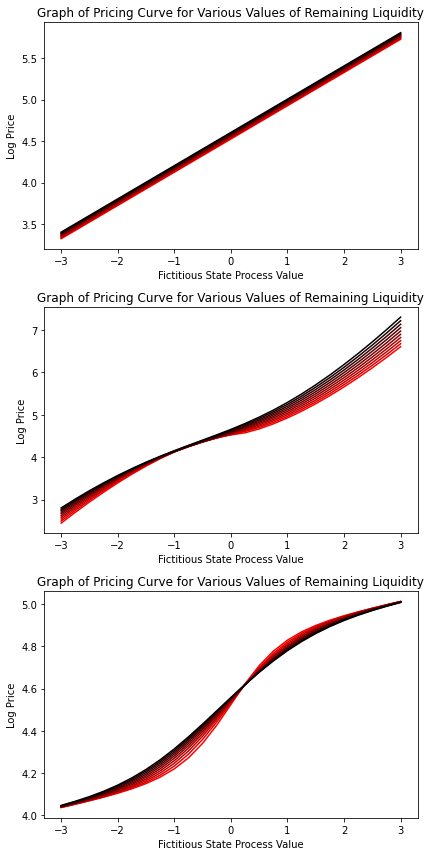

In [26]:
x_pts_0, solution_grid_0 = heat_eq_solution(time_pts, x_interval, grid_size, s = 1)
x_pts_1, solution_grid_1 = heat_eq_solution(time_pts, x_interval, grid_size, s = 1.5)
x_pts_2, solution_grid_2 = heat_eq_solution(time_pts, x_interval, grid_size, s = 1, mode = "sublinear")

fig, ax = plt.subplots(3)
fig.set_size_inches(6,3*4)

for i in range(len(time_pts)):
    if i == 0:
        for j in range(3):
            ax[j].set_title("Graph of Pricing Curve for Various Values of Remaining Liquidity")
            ax[j].set_xlabel("Fictitious State Process Value")
            ax[j].set_ylabel("Log Price")
    
    ax[0].plot(x_pts_0,np.log(solution_grid_0[i,:]), color = ((len(time_pts) - i - 1)/(len(time_pts) - 1)*1,0,0))
    ax[1].plot(x_pts_1,np.log(solution_grid_1[i,:]), color = ((len(time_pts) - i - 1)/(len(time_pts) - 1)*1,0,0))
    ax[2].plot(x_pts_2,np.log(solution_grid_2[i,:]), color = ((len(time_pts) - i - 1)/(len(time_pts) - 1)*1,0,0))


fig.tight_layout()

As the lines get more colorful, available liquidity decreases. The black line is for liquidity equal to 1 --- initial liquidity when $\rho = 0$ --- and the red line is the pricing curve for no remaining liquidity.

## The Distribution Of The Price For Selected Values of Remaining Liquidity

In [27]:
def PricingFunction(xi, liquidity, num_pts = 1000, m = 100, sigma = 0.4, s = 0, mode = "superlinear"):
    #Given the current value of adjusted order flow and remaining liquidity...
    #Plot the distribution of the price at the final time. 
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
    plt.title("Distribution of Final Price")
    plt.xlabel("Log Price")
    plt.ylabel("Probability")
    return plt.plot(np.log(h(norm_pts, m, sigma, s=s, mode=mode)),y_pts)
    
    

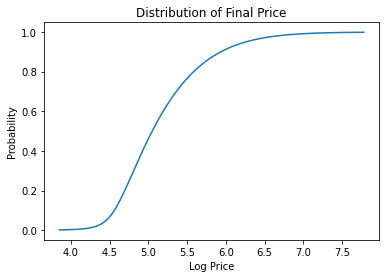

In [28]:
PricingFunction(1,0.5, s = 1)

## Experiment 1: Fixed Order Flow

Here, I am going to see what happens to the distribution of the final price when I fix the order flow value but allow liquidity and tail fatness to vary. While a "for loop" on PricingFunction techinically is sufficient to perform this task, I'm going to write a new function which will handle the iteration in a cleaner manner.

In [29]:
def Experiment_1(xi, liquidity_range, s_range, num_pts = 1000, m = 100, sigma = 0.4):
    #Given the current adjusted order flow value, compute the CDF for the final price for various values
    #of remaining liquidity and tail fatness.
    #NOTE: Negative values of s are interpreted as positive values of s in the sublinear value
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.outer(np.sqrt(liquidity_range),norm.ppf(y_pts))
    
    fig,ax = plt.subplots(len(liquidity_range),len(s_range))
    fig.set_size_inches(4*len(liquidity_range), 3*len(s_range))
    for i in range(len(liquidity_range)):
        for j in range(len(s_range)):
            if s_range[j] >= 0:
                ax[i,j].plot(np.log(h(norm_pts[i,:], m, sigma, s=s_range[j], mode="superlinear")),y_pts)
            else:
                ax[i,j].plot(np.log(h(norm_pts[i,:], m, sigma, s=-1*s_range[j], mode="sublinear")),y_pts)
            ax[i,j].set_title("CDF when (L,S) = (" + str(liquidity_range[i]) + "," + str(s_range[j]) + ")")
    
    fig.tight_layout()
    #fig.xlabel("Log Price")
    #plt.ylabel("Probability")
    return fig,ax
    

(<Figure size 864x648 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'CDF when (L,S) = (0.4,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.4,0)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.4,1)'}>],
        [<AxesSubplot:title={'center':'CDF when (L,S) = (0.5,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.5,0)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.5,1)'}>],
        [<AxesSubplot:title={'center':'CDF when (L,S) = (0.6,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.6,0)'}>,
         <AxesSubplot:title={'center':'CDF when (L,S) = (0.6,1)'}>]],
       dtype=object))

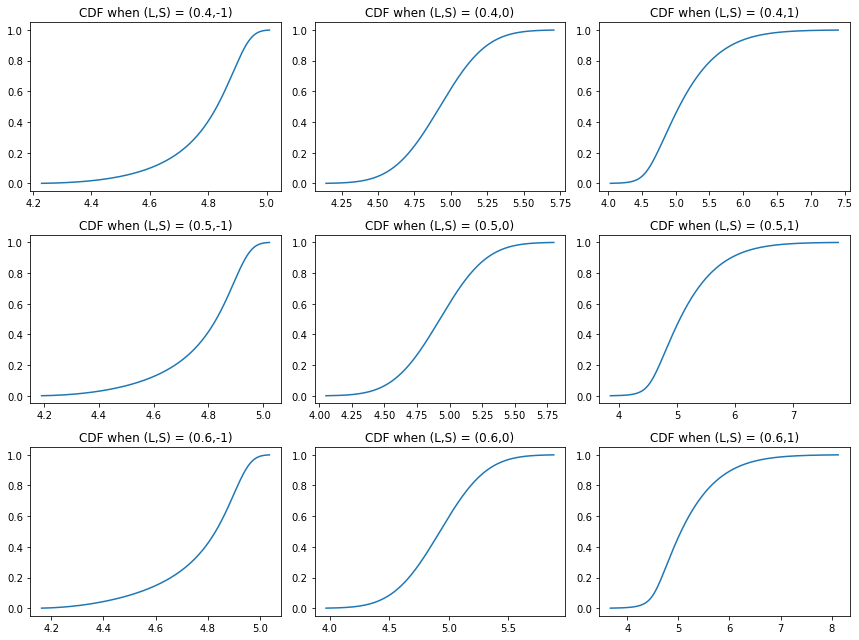

In [30]:
liquidity_range = [0.4,0.5,0.6]
s_range = [-1,0,1]
Experiment_1(1,liquidity_range, s_range)

## Experiment 2: Fixed Liquidity

Let's fix the liquidity to be constant and allow order flow and tail fatness to vary.

In [31]:
#This is just a helper function for quickly computing price for a given \xi and remaining liquidity \Sigma_t.

def current_price(xi, liquidity, s, num_pts= 1000, m = 100, sigma = 0.4, mode="superlinear", integration_mode = "standard"):
    
    #Integration method influences how the y_pts below used in the integreation process are picked
    #In the standard mode, I pick points evenly spaced in (0,1)
    #In the stretch mode, I pick points which are skewed more to the edges of (0,1)
    #In the random mode, I randomly pick points in (0,1) and then sort them.
    #In the random stretch, I randomly pick points in (0,1), sort them, and then skew them more towards the edges.
    
    if integration_mode == "standard":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    elif integration_mode == "random":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
    elif integration_mode == "stretch":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    elif integration_mode == "random_stretch":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
    
    #print(norm_pts)
    
    return ((num_pts + 1)/(num_pts-1))*np.trapz(h(norm_pts, m, sigma, s=s, mode=mode), x = y_pts)

In [32]:
def Experiment_2(xi_range, liquidity, s_range, num_pts = 1000, m = 100, sigma = 0.4):
    #Given the current adjusted order flow value, compute the CDF for the final price for various values
    #of remaining liquidity and tail fatness.
    #NOTE: Negative values of s are interpreted as positive values of s in the sublinear value
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = np.transpose(np.tile(xi_range,(num_pts,1))) + np.tile(np.sqrt(liquidity)*norm.ppf(y_pts), (3,1))
    
    fig,ax = plt.subplots(len(xi_range),len(s_range))
    fig.set_size_inches(4*len(xi_range), 3*len(s_range))
    
    x_min = np.log(100)
    x_max = np.log(100)
    for i in range(len(xi_range)):
        for j in range(len(s_range)):
            if s_range[j] >= 0:
                x_pts = np.log(h(norm_pts[i,:], m, sigma, s=s_range[j], mode="superlinear"))
                price_pts = [np.log(current_price(xi_range[i],liquidity, s_range[j], num_pts, m, sigma, mode="superlinear")) for k in range(len(y_pts))]
                ax[i,j].plot(x_pts,y_pts)
                ax[i,j].plot(price_pts,y_pts)
            else:
                x_pts = np.log(h(norm_pts[i,:], m, sigma, s=-1*s_range[j], mode="sublinear"))
                price_pts = [np.log(current_price(xi_range[i],liquidity, -1*s_range[j], num_pts, m, sigma, mode="sublinear")) for k in range(len(y_pts))]
                ax[i,j].plot(x_pts,y_pts)
                ax[i,j].plot(price_pts,y_pts)
            
            if min(x_pts) < x_min:
                x_min = min(x_pts)
            if max(x_pts) > x_max:
                x_max = max(x_pts)
            
            ax[i,j].set_title("CDF when (xi,S) = (" + str(xi_range[i]) + "," + str(s_range[j]) + ")")
    
    for i in range(len(xi_range)):
        for j in range(len(s_range)):
            ax[i,j].set_xlim(0.8*x_min+0.2*x_max,0.2*x_min+0.8*x_max)
    
    fig.tight_layout()
    #fig.xlabel("Log Price")
    #plt.ylabel("Probability")
    return fig,ax

(<Figure size 864x648 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'CDF when (xi,S) = (-1,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (-1,0)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (-1,1)'}>],
        [<AxesSubplot:title={'center':'CDF when (xi,S) = (0,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (0,0)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (0,1)'}>],
        [<AxesSubplot:title={'center':'CDF when (xi,S) = (1,-1)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (1,0)'}>,
         <AxesSubplot:title={'center':'CDF when (xi,S) = (1,1)'}>]],
       dtype=object))

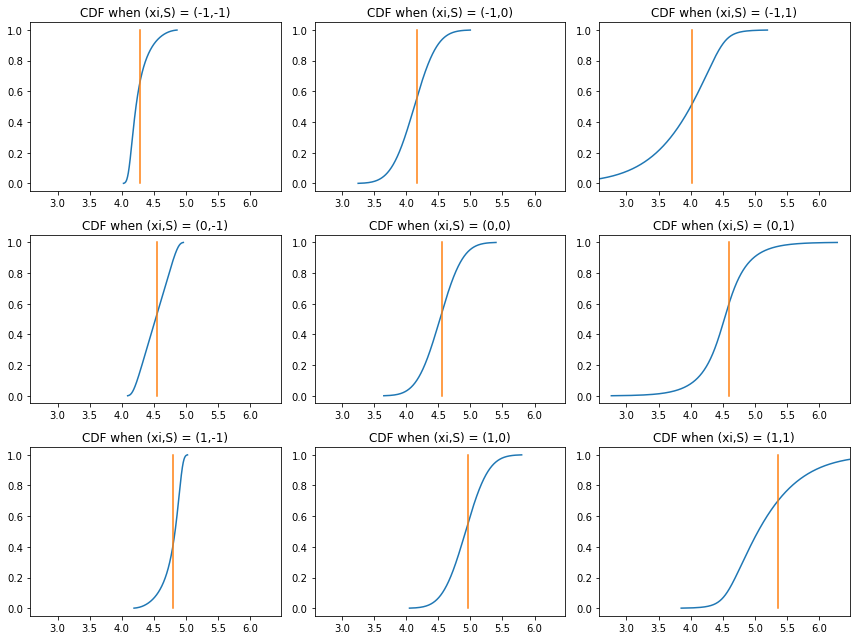

In [33]:
xi_range = [-1,0,1]
s_range = [-1,0,1]
Experiment_2(xi_range,0.5, s_range)

First, let me explain what is happening above. Depending on the value of adjusted order flow $\xi$, the probability curve CDF shifts to the left or right. Clearly, lower/higher values of $\xi_t$ imply a higher/lower mean value of $\xi_T$. However, we also see in the superlinear/sublinear case that the *shape* of the CDF curve changes:
1. In the superlinear case, when $\xi$ increases/decreases, the right tail of the CDF becomes fatter/thinner than the left, reflecting in this case the higher likelihood of extreme values.
2. In the sublinear case, when $\xi$ increases/decreases, the right tail of the CDF becomes thinner/fatter than the left, reflecting in this case lower likelihood of extreme values.

# Option Prices

Now I will construct a function which will tell me the price of an option given current order flow value, remaining liquidity, and tail fatness.

In [34]:
def OptionPrices(strike_range, xi, liquidity, s=0, num_pts = 1000, m = 100, sigma = 0.4, mode = "superlinear"):
    y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
    
    payout_grid = np.maximum(np.tile(h(norm_pts, m, sigma, s=s, mode=mode),(len(strike_range),1)) - np.transpose(np.tile(strike_range, (num_pts, 1))),0)
    print(np.shape(payout_grid))
    return np.mean(payout_grid, axis = 1)

Price at the current time: 99.95207781153361
(100, 5000)


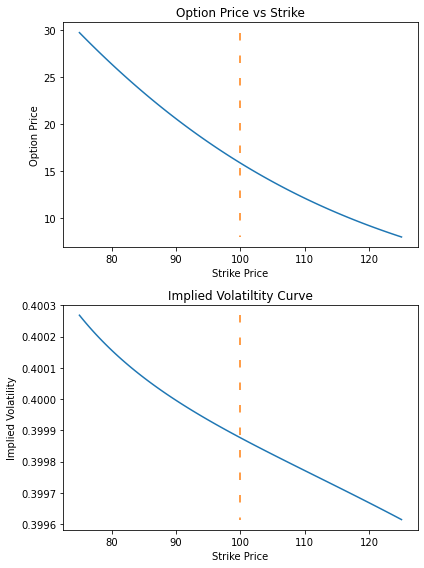

In [35]:
m = 100
sigma = 0.4
s = 0
mode = "superlinear"
xi = 0.0
liquidity = 1
num_pts = 5000

y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
P_0 = ((num_pts + 1)/(num_pts-1))*np.trapz(h(norm_pts, m, sigma, s=s, mode=mode), x = y_pts)
print("Price at the current time: " + str(P_0))

n = 100
strike_range = [75 + 50*(i/(n-1)) for i in range(n)]
option_prices = OptionPrices(strike_range, xi, liquidity, s=s, num_pts=num_pts, m=m, sigma=sigma, mode=mode)

fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)

impVols = []
for j in range(len(option_prices)):
    impVols.append(dp.impVol(option_prices[j], liquidity, strike_range[j], 0, P_0, "call", sigma, 20))

ax[0].plot(strike_range, option_prices)
ax[0].plot([P_0 for i in range(len(option_prices))],option_prices, linestyle = (0,(5,10)))
ax[0].set_title("Option Price vs Strike")
ax[0].set_xlabel("Strike Price")
ax[0].set_ylabel("Option Price")

ax[1].plot(strike_range, impVols)
ax[1].plot([P_0 for i in range(len(option_prices))],impVols, linestyle = (0,(5,10)))
ax[1].set_title("Implied Volatiltity Curve")
ax[1].set_xlabel("Strike Price")
ax[1].set_ylabel("Implied Volatility")

fig.tight_layout()

Now, given a set of option prices, we want to find the implied volatility, so let's do just that.

## Strikes, Order Flow, & the Options Chain

In this subsection, I want to see how, keeping everything else equal, the value of $\xi$ influences the IV curve shape. The below function computes many option prices at once to make this job easy.

In [36]:
def options_exp_1(strike_range, xi_range, liquidity, 
                  s=0, num_pts = 1000, m = 100, sigma = 0.4, mode = "superlinear", integration_mode = "standard", 
                  weights = [], means = [], volatilities = []):
    fudge_factor = (num_pts + 1)/(num_pts - 1)
    
    #Integration method influences how the y_pts below used in the integreation process are picked
    #In the standard mode, I pick points evenly spaced in (0,1)
    #In the stretch mode, I pick points which are skewed more to the edges of (0,1)
    #In the random mode, I randomly pick points in (0,1) and then sort them.
    #In the random stretch, I randomly pick points in (0,1), sort them, and then skew them more towards the edges.
    
    #Mode influences the market maker's prior:
    #"superlinear" and "sublinear" are modifications of the market maker's prior where we replace the normal with something that has fatter/thinner tails respectively.
    #"power" is like superlinear, but uses a power function to create the wider tails. 
    #TODO: Smirk
    
    #TODO: "mixture" assumes the logprice is distributed according to Gaussian mixture. 
    #In order to use this mode, additional parameters "weights", "means", and "volatilities" must be specified.
    #Note in this mode that values in means should correspond with values of ln(m) - 0.5*sigma^2 
    
    if integration_mode == "standard":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    elif integration_mode == "random":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
    elif integration_mode == "stretch":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    elif integration_mode == "random_stretch":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    
    plt.plot(y_pts)
    
    #Here
    norm_pts = np.transpose(np.tile(xi_range, (num_pts,1))) + np.tile(np.sqrt(liquidity)*norm.ppf(y_pts), (len(xi_range),1))
    
    #This is not the most efficient way to write this but it is easier to write
    option_prices = np.zeros((len(strike_range),len(xi_range)))
    impVols = np.zeros((len(strike_range),len(xi_range)))
    #print(xi_range)
    #print(strike_range)
    #print(np.shape(option_prices))
    
    #Form a 2d array of call option prices. 
    #Each row corresponds with a strike
    #Each column corresponds with a value of xi
    for i in range(len(strike_range)):
        
        if mode != "mixture":
            payout_grid = np.maximum(h(norm_pts, m, sigma, s=s, mode=mode) - strike_range[i],0)
        else: #mode == mixture
            #The mixture mode does not play as nice, hence we need to do this
            #print(norm_pts)
            payout_grid = np.maximum(hGM(norm_pts, weights, means, volatilities, iterations = 4).reshape(len(xi_range),num_pts) - strike_range[i],0)
        
        option_prices[i,:] = fudge_factor*np.trapz(payout_grid, x = y_pts, axis = 1)
    
    #and here
    if mode != "mixture":
        P_0 = ((num_pts + 1)/(num_pts-1))*np.trapz(h(norm_pts, m, sigma, s=s, mode=mode), x = y_pts, axis = 1)
    else:
        #This is known to be suboptimal, but I just want code that works first
        P_0 = ((num_pts + 1)/(num_pts-1))*np.trapz(hGM(norm_pts, weights, means, volatilities, iterations = 4).reshape(len(xi_range),num_pts), x = y_pts, axis = 1)
    print(P_0)
    
    for i in range(len(strike_range)):
        for j in range(len(xi_range)):
            impVols[i,j] = dp.impVolBisection(option_prices[i,j], 1, strike_range[i], 0, P_0[j], "call", sigma, 10)
    
    return option_prices, impVols

### Example Case 1: Superlinearity with a log-based function

Using the "superlinear" mode from h.

[ 95.32399554  97.41936304  99.56702215 101.77954293 104.07056642]


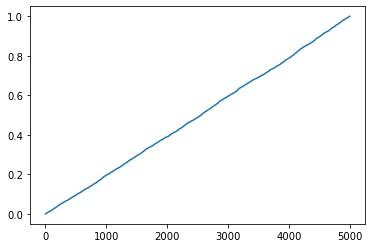

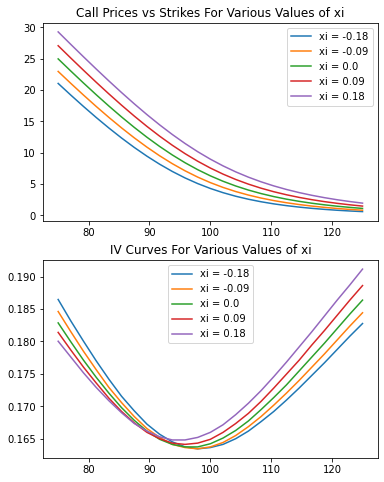

In [37]:
m = 100
sigma = 0.2
s = 0.5
mode = "superlinear"
liquidity = 0.5
xi_n = 5
xi_range = [-0.25*np.sqrt(1 - liquidity) + 0.5*np.sqrt(1 - liquidity)*(i/(xi_n-1)) for i in range(xi_n)]
num_pts = 5000

strike_n = 25
strike_range = [75 + 50*(i/(strike_n-1)) for i in range(strike_n)]

option_prices, impVols = options_exp_1(strike_range, xi_range, liquidity, s=s, num_pts=num_pts, m=m, sigma=sigma, mode=mode, integration_mode="random")

fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)

legend = []
for i in range(np.shape(option_prices)[1]):
    ax[0].plot(strike_range, option_prices[:,i])
    ax[1].plot(strike_range, impVols[:,i])
    legend.append('xi = ' + str(np.round(xi_range[i],2)))

ax[0].set_title("Call Prices vs Strikes For Various Values of xi")
ax[1].set_title("IV Curves For Various Values of xi")
ax[0].legend(legend)
ax[1].legend(legend)

We get significant numerical instability in our results if we try and compute deep ITM or deep OTM options. In last week's research this was reserved for a small portion of the results, but here it is impacting a signficant portion of said results, which is stopping us from delivering meaningful measurements.

### Test Case 2: The Gaussian Mixture Case

According to Glasserman, an n=3 Gaussian mixture can produce an IV curve that is W-shaped. We test that below here:

In [38]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.25 0.5  0.25]
Mean Prices: [0.79600998 0.8824969  1.19401498]
Volatilities: [0.1 0.5 0.1]


In [39]:
m = np.array([0.6,1.4])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.25,0.25])
o = 0.50
w = np.array([0.5,0.5])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.5 0.5]
Mean Prices: [0.58153994 1.35692653]
Volatilities: [0.25 0.25]


[0.76122689 0.80538224 0.85220742 0.90157266 0.95330713 1.00720635
 1.06304171 1.12057118 1.1795507  1.23974526]


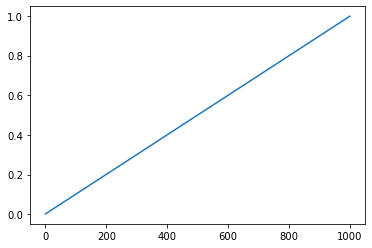

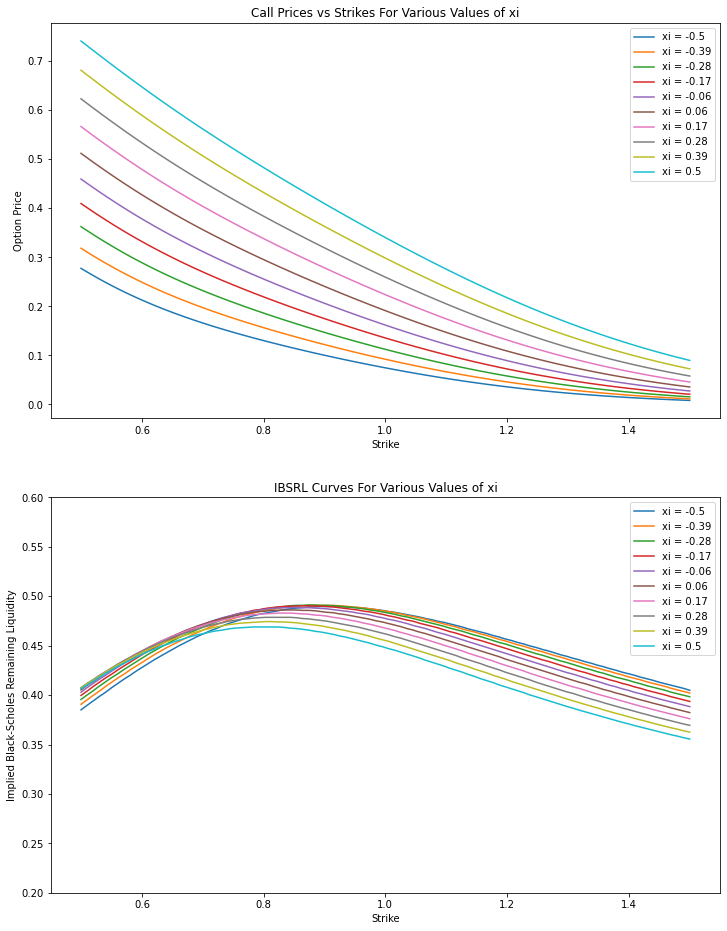

In [40]:
mode = "mixture"
liquidity = 0.75
xi_n = 10
xi_range = [-1*np.sqrt(1 - liquidity) + 2*np.sqrt(1 - liquidity)*(i/(xi_n-1)) for i in range(xi_n)]
num_pts = 1000

strike_n = 100
strike_range = [0.5 + 1.0*(i/(strike_n-1)) for i in range(strike_n)]

option_prices, impVols = options_exp_1(strike_range, xi_range, liquidity, num_pts=num_pts, m=m, mode=mode, integration_mode="standard",
                                       weights = weights, means = means, volatilities = volatilities)

fig, ax = plt.subplots(2)
fig.set_size_inches(12,16)

legend = []
for i in range(np.shape(option_prices)[1]):
    ax[0].plot(strike_range, option_prices[:,i])
    ax[1].plot(strike_range, impVols[:,i])
    legend.append('xi = ' + str(np.round(xi_range[i],2)))

ax[0].set_title("Call Prices vs Strikes For Various Values of xi")
ax[1].set_title("IBSRL Curves For Various Values of xi")

ax[0].set_xlabel("Strike")
ax[1].set_xlabel("Strike")

ax[0].set_ylabel("Option Price")
ax[1].set_ylabel("Implied Black-Scholes Remaining Liquidity")

ax[1].set_ylim([0.2,0.6])
ax[0].legend(legend)
ax[1].legend(legend)

## Experiment 2: Liquidity

TODO: Modify this function to support the Gaussian mixture case. Now let's see the impact that changing liquidity will have on the IV curve:

In [41]:
def options_exp_2(strike_range, xi, liquidity_range, 
                  s=0, num_pts = 1000, m = 100, sigma = 0.4, mode = "superlinear", integration_mode = "standard",
                  weights = [], means = [], volatilities = []):
    
    fudge_factor = (num_pts + 1)/(num_pts - 1)
    
    #Integration method influences how the y_pts below used in the integreation process are picked
    #In the standard mode, I pick points evenly spaced in (0,1)
    #In the stretch mode, I pick points which are skewed more to the edges of (0,1)
    #In the random mode, I randomly pick points in (0,1) and then sort them.
    #In the random stretch, I randomly pick points in (0,1), sort them, and then skew them more towards the edges.
    
    if integration_mode == "standard":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    elif integration_mode == "random":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
    elif integration_mode == "stretch":
        y_pts = np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    elif integration_mode == "random_stretch":
        y_pts = np.random.uniform(size = num_pts)
        y_pts = np.sort(y_pts)
        y_pts = 0.5*(np.cbrt(2*y_pts-1)+1)
    
    #plt.plot(y_pts)
    
    #GOAL: For each value of liquidity in liquidity_range, graph the IV curve for the options
    
    #Computing the norm_pts
    norm_pts = xi + np.reshape(np.sqrt(liquidity_range),(len(liquidity_range),1))*np.tile(norm.ppf(y_pts),(len(liquidity_range),1))
    
    #Now that I have the points, let's compute the option payouts. Each row has information concerning a different value of remaining liquidity.
    option_prices = np.zeros((len(strike_range),len(liquidity_range)))
    impVols = np.zeros((len(strike_range),len(liquidity_range)))
    for i in range(len(strike_range)):
        #Each row of option_prices corresponds with a strike price
        #Each column corresponds with a liquidity value
        if mode != "mixture":
            payout_grid = np.maximum(h(norm_pts, m, sigma, s=s, mode=mode) - strike_range[i],0)
        else:
            payout_grid = np.maximum(hGM(norm_pts, weights, means, volatilities, iterations = 4).reshape(len(liquidity_range),num_pts) - strike_range[i],0)
        option_prices[i,:] = fudge_factor*np.trapz(payout_grid, x = y_pts, axis = 1)
        
    #Once I get the option payouts, now it's time to get the implied volatilities!
    if mode != "mixture":
        P_0 = ((num_pts + 1)/(num_pts-1))*np.trapz(h(norm_pts, m, sigma, s=s, mode=mode), x = y_pts, axis = 1)
    else:
        P_0 = ((num_pts + 1)/(num_pts-1))*np.trapz(hGM(norm_pts, weights, means, volatilities, iterations = 4).reshape(len(liquidity_range),num_pts), x = y_pts, axis = 1)
    
    for j in range(len(liquidity_range)):
        print("Current price at liquidity value " + str(liquidity_range[j]) + ": " + str(P_0[j]))
        for i in range(len(strike_range)):
            print("Pricing option for strike " + str(np.round(strike_range[i],2)) + " and liquidity " + str(np.round(liquidity_range[j],2)))
            impVols[i,j] = dp.impVolBisection(option_prices[i,j], 1, strike_range[i], 0, P_0[j], "call", sigma, 10)
    return option_prices, impVols

### Example Case 1 - Superlinear

Current price at liquidity value 1.0: 110.46412959854118
Pricing option for strike 75.0 and liquidity 1.0
Pricing option for strike 77.08 and liquidity 1.0
Pricing option for strike 79.17 and liquidity 1.0
Pricing option for strike 81.25 and liquidity 1.0
Pricing option for strike 83.33 and liquidity 1.0
Pricing option for strike 85.42 and liquidity 1.0
Pricing option for strike 87.5 and liquidity 1.0
Pricing option for strike 89.58 and liquidity 1.0
Pricing option for strike 91.67 and liquidity 1.0
Pricing option for strike 93.75 and liquidity 1.0
Pricing option for strike 95.83 and liquidity 1.0
Pricing option for strike 97.92 and liquidity 1.0
Pricing option for strike 100.0 and liquidity 1.0
Pricing option for strike 102.08 and liquidity 1.0
Pricing option for strike 104.17 and liquidity 1.0
Pricing option for strike 106.25 and liquidity 1.0
Pricing option for strike 108.33 and liquidity 1.0
Pricing option for strike 110.42 and liquidity 1.0
Pricing option for strike 112.5 and liqu

Pricing option for strike 108.33 and liquidity 0.4
Pricing option for strike 110.42 and liquidity 0.4
Pricing option for strike 112.5 and liquidity 0.4
Pricing option for strike 114.58 and liquidity 0.4
Pricing option for strike 116.67 and liquidity 0.4
Pricing option for strike 118.75 and liquidity 0.4
Pricing option for strike 120.83 and liquidity 0.4
Pricing option for strike 122.92 and liquidity 0.4
Pricing option for strike 125.0 and liquidity 0.4
Current price at liquidity value 0.29999999999999993: 104.48442190399444
Pricing option for strike 75.0 and liquidity 0.3
Pricing option for strike 77.08 and liquidity 0.3
Pricing option for strike 79.17 and liquidity 0.3
Pricing option for strike 81.25 and liquidity 0.3
Pricing option for strike 83.33 and liquidity 0.3
Pricing option for strike 85.42 and liquidity 0.3
Pricing option for strike 87.5 and liquidity 0.3
Pricing option for strike 89.58 and liquidity 0.3
Pricing option for strike 91.67 and liquidity 0.3
Pricing option for str

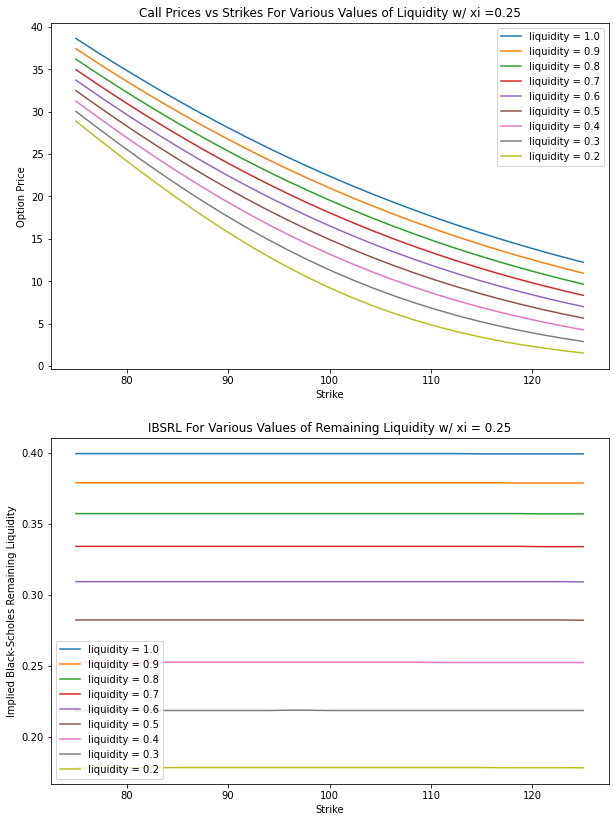

In [42]:
m = 100
sigma = 0.4
s = 0.0
mode = "superlinear"
n = 9
liquidity_range = [1 - 0.8*(i/(n-1)) for i in range(n)]
xi = 0.25
num_pts = 5000

strike_n = 25
strike_range = [75 + 50*(i/(strike_n-1)) for i in range(strike_n)]

option_prices, impVols = options_exp_2(strike_range, xi, liquidity_range, s=s, num_pts = num_pts, m = 100, sigma = sigma, mode = mode, integration_mode = "standard")

#Graphing the results
#Each column contains information about the call option prices and IVs
fig, ax = plt.subplots(2)
fig.set_size_inches(10,14)

legend = []
for i in range(np.shape(option_prices)[1]):
    ax[0].plot(strike_range, option_prices[:,i])
    ax[1].plot(strike_range, impVols[:,i])
    legend.append('liquidity = ' + str(np.round(liquidity_range[i],2)))

ax[0].set_title("Call Prices vs Strikes For Various Values of Liquidity w/ xi =" + str(xi))
ax[1].set_title("IBSRL For Various Values of Remaining Liquidity w/ xi = " + str(xi))

ax[0].set_xlabel("Strike")
ax[1].set_xlabel("Strike")

ax[0].set_ylabel("Option Price")
ax[1].set_ylabel("Implied Black-Scholes Remaining Liquidity")

ax[0].legend(legend)
ax[1].legend(legend)

#We also need to print the prices for full context
for i in range(len(liquidity_range)):
    print("Price for liquidity = " + str(np.round(liquidity_range[i],2)) + ": " + str(np.round(current_price(xi, liquidity_range[i], s, num_pts, m, sigma, mode=mode),4)))

### Example Case 2: The Gaussian Mixture

Testing the Gaussian Mixture

In [49]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.25 0.5  0.25]
Mean Prices: [0.79600998 0.8824969  1.19401498]
Volatilities: [0.1 0.5 0.1]


In [52]:
m = np.array([0.6,1.4])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.25,0.25])
o = 0.50
w = np.array([0.5,0.5])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Weights: [0.5 0.5]
Mean Prices: [0.58153994 1.35692653]
Volatilities: [0.25 0.25]


Current price at liquidity value 1.0: 1.0007831801948621
Pricing option for strike 0.5 and liquidity 1.0
Pricing option for strike 0.51 and liquidity 1.0
Pricing option for strike 0.52 and liquidity 1.0
Pricing option for strike 0.53 and liquidity 1.0
Pricing option for strike 0.54 and liquidity 1.0
Pricing option for strike 0.55 and liquidity 1.0
Pricing option for strike 0.56 and liquidity 1.0
Pricing option for strike 0.57 and liquidity 1.0
Pricing option for strike 0.58 and liquidity 1.0
Pricing option for strike 0.59 and liquidity 1.0
Pricing option for strike 0.6 and liquidity 1.0
Pricing option for strike 0.61 and liquidity 1.0
Pricing option for strike 0.62 and liquidity 1.0
Pricing option for strike 0.63 and liquidity 1.0
Pricing option for strike 0.64 and liquidity 1.0
Pricing option for strike 0.65 and liquidity 1.0
Pricing option for strike 0.66 and liquidity 1.0
Pricing option for strike 0.67 and liquidity 1.0
Pricing option for strike 0.68 and liquidity 1.0
Pricing option

Pricing option for strike 1.16 and liquidity 0.75
Pricing option for strike 1.17 and liquidity 0.75
Pricing option for strike 1.18 and liquidity 0.75
Pricing option for strike 1.19 and liquidity 0.75
Pricing option for strike 1.2 and liquidity 0.75
Pricing option for strike 1.21 and liquidity 0.75
Pricing option for strike 1.22 and liquidity 0.75
Pricing option for strike 1.23 and liquidity 0.75
Pricing option for strike 1.24 and liquidity 0.75
Pricing option for strike 1.25 and liquidity 0.75
Pricing option for strike 1.26 and liquidity 0.75
Pricing option for strike 1.27 and liquidity 0.75
Pricing option for strike 1.28 and liquidity 0.75
Pricing option for strike 1.29 and liquidity 0.75
Pricing option for strike 1.3 and liquidity 0.75
Pricing option for strike 1.31 and liquidity 0.75
Pricing option for strike 1.32 and liquidity 0.75
Pricing option for strike 1.33 and liquidity 0.75
Pricing option for strike 1.34 and liquidity 0.75
Pricing option for strike 1.35 and liquidity 0.75
Pr

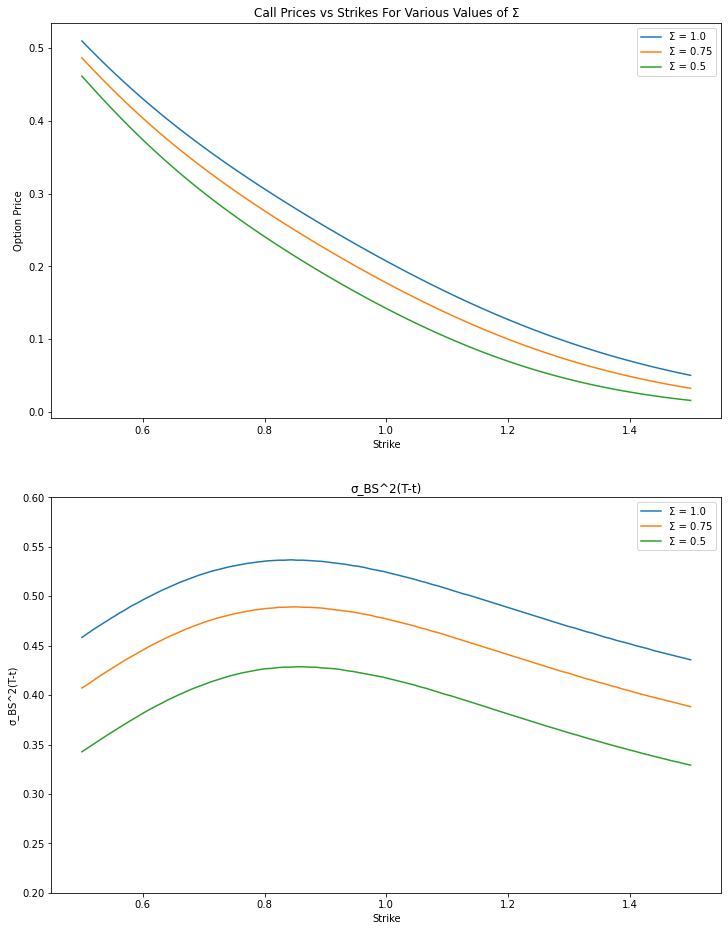

In [53]:
mode = "mixture"
n = 3
liquidity_range = [1 - 0.5*(i/(n-1)) for i in range(n)]
xi = 0
num_pts = 10000

strike_n = 100
strike_range = [0.5 + 1.0*(i/(strike_n-1)) for i in range(strike_n)]

option_prices, impVols = options_exp_2(strike_range, xi, liquidity_range, num_pts=num_pts, m=m, mode=mode, integration_mode="standard",
                                       weights = weights, means = means, volatilities = volatilities)

fig, ax = plt.subplots(2)
fig.set_size_inches(12,16)

legend = []
for i in range(np.shape(option_prices)[1]):
    ax[0].plot(strike_range, option_prices[:,i])
    ax[1].plot(strike_range, impVols[:,i])
    legend.append('Σ = ' + str(np.round(liquidity_range[i],2)))

ax[0].set_title("Call Prices vs Strikes For Various Values of Σ")
ax[1].set_title("σ_BS^2(T-t)")

ax[0].set_xlabel("Strike")
ax[1].set_xlabel("Strike")

ax[0].set_ylabel("Option Price")
ax[1].set_ylabel("σ_BS^2(T-t)")

ax[1].set_ylim([0.2,0.6])
ax[0].legend(legend)
ax[1].legend(legend)

In [46]:
h(0, 100, 0.2, s = 1, mode = "power")

98.01986733067552

# PDF Crossings

In the work of Glasserman and Pirjol, the shape of IV curve can be characterized by the number of crossings between the lognormal PDF and the stock price PDF. Here, I will try and build code which can efficiently count the number of such crossings. I will start simple, with just a version suitable for Glasserman and Pirjol before generalizing it to our model.

First, let's compute the CDF

In [47]:
def PricingFunctionValues(xi, liquidity, num_pts = 1000, m = 100, sigma = 0.4, s = 0, mode = "superlinear"):
    #Given the current value of adjusted order flow and remaining liquidity...
    #Plot the distribution of the price at the final time. 
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
    return np.log(h(norm_pts, m, sigma, s=s, mode=mode)), y_pts 

hGM(x, weights, means, volatilities, iterations = 4)

NameError: name 'x' is not defined

Here's a graph so we can visualize the CDF function. I'm writing it as a function of log-price rather than regular price as it's more presentable this way.

In [ ]:
x_pts,y_pts = PricingFunctionValues(0,1)

plt.title("Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("Probability")
plt.plot(x_pts,y_pts)

Let's define the derivative.

In [ ]:
def dfdx_mid(x_pts,y_pts):
    #Use a linear interpolant on the interval between x_i and x_i+1 to compute the derivative of f(x)
    y_left = y_pts[0:-2]
    y_right = y_pts[1:-1]
    
    x_left = x_pts[0:-2]
    x_right = x_pts[1:-1]
    
    return (x_left + x_right)/2, (y_right - y_left)/(x_right - x_left)

In [ ]:
delta_x_pts, delta_y_pts = dfdx_mid(x_pts,y_pts)
plt.title("Probability Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("PDF value")
plt.plot(delta_x_pts,delta_y_pts)

There are more robust methods for computing a derivative, but let's worry about those methods later. For now, we have enough tools in the bag to compute the number of function crossings between a Gaussian mixture and a lognormal random variable, which I will now demonstrate:

Start off by setting the parameters for the Gaussian Mixture random variable

In [ ]:
m = np.array([0.8,1,1.2])
#v = np.exp(-1.6 + 0.7*norm.rvs(size=n_comp))
v = np.array([0.1,0.5,0.1])
o = 0.50
w = np.array([(1-o)/2, o, (1-o)/2])

means = np.array(np.log(m) - 0.5*(v**2))
volatilities = v
weights = w

print("Weights: " + str(weights))
print("Mean Prices: " + str(np.exp(means)))
print("Volatilities: " + str(volatilities))

Next we need a special version of our pricing function from earlier for the Gaussian mixture case

In [ ]:
xi = 0
liquidity = 1
num_pts = 5000

In [ ]:
def PricingFunctionGM(xi, liquidity, num_pts = 1000, means = [], volatilities = [], weights = [], iterations = 4):
    #Special version of pricing function adapted for the Gaussian Mixture case
    y_pts =  np.array([(i+1)/(num_pts+1) for i in range(num_pts)])
    norm_pts = xi + np.sqrt(liquidity)*norm.ppf(y_pts)
    return np.log(hGM(norm_pts, weights, means, volatilities, iterations = iterations)), y_pts 

In [ ]:
x_pts_GM,y_pts_GM = PricingFunctionGM(xi, liquidity, num_pts = num_pts, means = means, volatilities = volatilities, weights = weights)

plt.title("Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("Probability")
plt.plot(x_pts_GM,y_pts_GM)

We really need the derivative though...

In [ ]:
delta_x_pts_GM, delta_y_pts_GM = dfdx_mid(x_pts_GM,y_pts_GM)
plt.title("Probability Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("PDF value")
plt.plot(delta_x_pts_GM,delta_y_pts_GM)

We want to compare against a lognormal random variable which carries the same expectation.

In [ ]:
m = np.mean(np.exp(x_pts_GM))
x_pts, y_pts = PricingFunctionValues(xi, liquidity, num_pts = num_pts, m = m, sigma = 0.4, s = 0, mode = "superlinear")

In [ ]:
plt.title("Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("Probability")
plt.plot(x_pts,y_pts)

In [ ]:
delta_x_pts, delta_y_pts = dfdx_mid(x_pts,y_pts)
plt.title("Probability Distribution of Final Price")
plt.xlabel("Log Price")
plt.ylabel("PDF value")
plt.plot(delta_x_pts,delta_y_pts)

Now let's compute the function crossings!

In [ ]:
plt.plot(delta_x_pts_GM,delta_y_pts_GM)
plt.plot(delta_x_pts,delta_y_pts)

In [ ]:
f_GM = interp1d(delta_x_pts_GM,delta_y_pts_GM)
f_lognormal = interp1d(delta_x_pts,delta_y_pts)

In [ ]:
x_a = max(delta_x_pts[0],delta_x_pts_GM[0])
x_b = min(delta_x_pts[-1],delta_x_pts_GM[-1])

In [ ]:
xnew = np.linspace(x_a,x_b, num=5000, endpoint=True)
plt.plot(xnew,f_GM(xnew) - f_lognormal(xnew))

y = f_GM(xnew) - f_lognormal(xnew)
zero_crossings = np.where(np.diff(np.sign(y)))[0]
print(len(zero_crossings))

# SCRAP

In [ ]:
        old_y = np.copy(a)
        y = np.copy(b)
        for i in range(iterations):
            
            #print("Values of old_y and y: ")
            #print(old_y)
            #print(y)
            
            f = dp.GaussianMixtureCDF(y, weights, means, volatilities) - phi_x
            old_f = dp.GaussianMixtureCDF(old_y, weights, means, volatilities) - phi_x
            
            #print("Values of f and old_f: ")
            #print(f)
            #print(old_f)
            new_y = y - f*(y - old_y)/(f - old_f)
            
            #Check that each entry in new_y is a suitable guess. If it's not, reject the guess for the bad indices and use bisection method in its place instead.
            bad_indices = np.where((new_y < a) | (new_y > b) | np.isnan(new_y))[0]
            print("bad indices: ")
            print(bad_indices)
            if len(bad_indices) > 0:
                print("Some indices came out bad. Performing bisection method on...")
                print(bad_indices)
                t = (a + b)/2
                f_t = dp.GaussianMixtureCDF(t, weights, means, volatilities) - phi_x
                b[np.where((f_t > 0) & ((new_y < a) | (new_y > b) | np.isnan(new_y)))[0]] = t[np.where((f_t > 0) & ((new_y < a) | (new_y > b) | np.isnan(new_y)))[0]]
                a[np.where((f_t < 0) & ((new_y < a) | (new_y > b) | np.isnan(new_y)))[0]] = t[np.where((f_t < 0) & ((new_y < a) | (new_y > b) | np.isnan(new_y)))[0]]
                
            old_y = np.copy(y[np.where((new_y > a) & (new_y < b))])
            y[np.where((new_y > a) & (new_y < b))] = np.copy(new_y[np.where((new_y > a) & (new_y < b))])
            print("Guess after iteration " + str(i) + ": ")
            print(y)
            print("The answer must lie in between: ")
            print(a)
            print(b)
            #print(np.where((new_y > a) & (new_y < b)))
            print("------------------------------")